In [151]:
!pip install python_speech_features
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
import pandas as pd  # library for data manipulation and analysis
import os  # module for interacting with the operating system
import shutil  # module for high-level file operations
import numpy as np  # library for numerical computing
import scipy.io.wavfile as wav  # module for reading and writing WAV files
import matplotlib.pyplot as plt  # library for plotting data
from tqdm import tqdm_notebook as tqdm  # module for creating progress bars

# deep learning libraries
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
from tensorflow.keras.layers import LSTM, Dense, Masking

# machine learning libraries
from sklearn.model_selection import train_test_split  # module for splitting data into train and test sets
from sklearn.metrics import f1_score  # function for calculating F1 score

# audio signal processing libraries
from python_speech_features import mfcc  # module for computing Mel Frequency Cepstral Coefficients (MFCCs)
from IPython.display import Audio, display  # module for playing audio files

import torch
# from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import Levenshtein as Lev
import numpy as np
from sklearn.metrics import precision_recall_fscore_support


In [153]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load dataset and preprocessing

In [154]:
df = pd.read_excel('/content/drive/MyDrive/Deep_HW4/Persian-Speech-To-Text-Maps.xlsx')

In [155]:
file_name = '/content/drive/MyDrive/Deep_HW4/'
file_name += os.listdir(file_name)[0]

(rate,sig) = wav.read(file_name)

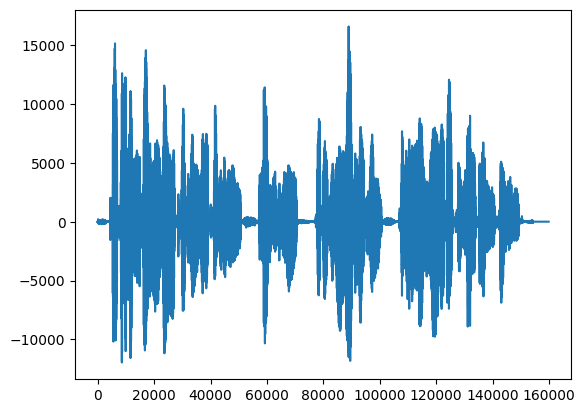

In [156]:
plt.plot(sig)

In [157]:
wn = Audio(file_name, autoplay=False)
display(wn)

In [158]:
mfcc_features = mfcc(sig,rate)
print(mfcc_features.shape)

(998, 13)


In [159]:
mfcc_features

array([[ 1.30932080e+01, -2.44196437e+01, -2.07298229e+01, ...,
         1.68742238e+00,  1.99083231e+00,  2.30764976e+01],
       [ 1.30686631e+01, -2.52849135e+01, -2.26187419e+01, ...,
        -3.85724760e+00, -8.59394675e+00,  1.15634546e+01],
       [ 1.30813045e+01, -2.31643496e+01, -2.26848286e+01, ...,
        -3.73817777e+00, -1.44849571e+01,  1.20279411e+01],
       ...,
       [-3.60436534e+01,  0.00000000e+00,  0.00000000e+00, ...,
         9.64028692e-15,  0.00000000e+00,  0.00000000e+00],
       [-3.60436534e+01,  0.00000000e+00,  0.00000000e+00, ...,
         9.64028692e-15,  0.00000000e+00,  0.00000000e+00],
       [-3.60436534e+01,  0.00000000e+00,  0.00000000e+00, ...,
         9.64028692e-15,  0.00000000e+00,  0.00000000e+00]])

In [160]:
df['MFCC features'] = None

In [161]:
for i in range(500):
    text = df.loc[i, 'audio']
    loc = text.replace("myaudio/", "")
    file_name = '/content/drive/MyDrive/Deep_HW4/' + loc
    (rate,sig) = wav.read(file_name)
    mfcc_features = mfcc(sig,rate)
    df.loc[i, 'MFCC features'] = [mfcc_features]

In [162]:
unique_chars = pd.unique(list(df['text'].sum()))
unique_chars.sort()

for char in unique_chars:
    print(char)

 
آ
أ
ئ
ا
ب
ت
ث
ج
ح
خ
د
ذ
ر
ز
س
ش
ص
ض
ط
ظ
ع
غ
ف
ق
ل
م
ن
ه
و
ً
پ
چ
ژ
ک
گ
ی


In [163]:
# unique_chars[30]

In [164]:
# Define a dictionary of hard-to-read characters and their replacements
char_dict = {'آ': 'ا', 'أ': 'ا', 'ئ': 'ی', unique_chars[30]: 'ن'}

# Convert the keys and values in char_dict to Unicode code points
char_codepoints = {ord(k): ord(v) for k, v in char_dict.items()}

# Apply the character mapping to the 'text' column of the DataFrame
def translate_text(text):
    """Translates a string by replacing hard-to-read characters."""
    return text.translate(char_codepoints)

df['text'] = df['text'].apply(translate_text)

In [165]:
df

,audio,text,MFCC features
0,myaudio/12440123.wav,ابنبات های تومک را گرفت گفت ممنون پسرم نه من ...,"[[[11.53494370737191, -3.370294705789073, -4.2..."
1,myaudio/12440124.wav,قبلا هم به تو گفتم هیچ وقتم استراحت ندارم فقط ...,"[[[10.105730436984143, -2.4352324174037996, -3..."
2,myaudio/12440126.wav,می شد او را یک فیلسوف به حساب اورد او عاشق چیز...,"[[[9.91634332069268, -2.5599461851402547, -4.9..."
3,myaudio/12440127.wav,اگر تومک فراموش می کرد برایش ابنبات بیاورد درس...,"[[[11.225249404021213, -3.406866944024388, -2...."
4,myaudio/12440128.wav,نان های ادویه دار قلبی شکل را بیشتر دوست داشت ...,"[[[8.637159353566885, -2.7571319924894624, -5...."
...,...,...,...
495,myaudio/12560439.wav,و زیبای شهر تهران به حساب می اید این پارک در ح...,"[[[15.512500755155884, -34.664955861022364, -1..."
496,myaudio/12560440.wav,باغ پرندگان تهران در شمال شرق تهران و در دل جن...,"[[[13.953515756973522, -2.395566524010967, -14..."
497,myaudio/12560443.wav,و مخصوص پرندگانی ایست که قابلیت پرواز دارند پو...,"[[[12.28639023707803, -27.30243460225483, -21...."
498,myaudio/12560444.wav,جلوگیری می کند احداث این باغ سه سال به طول انج...,"[[[13.19515533481687, -30.72443819788632, -10...."


In [166]:
# Define a list of unique characters for the target language
target_chars = unique_chars.tolist()

# Add special characters for blank, padding, start, and end
target_chars = ['-', '<PAD>', '<S>', '<E>'] + target_chars

# Create dictionaries to map characters to integers and vice versa
char_to_int = {char: index for index, char in enumerate(target_chars)}
int_to_char = {index: char for index, char in enumerate(target_chars)}

In [167]:
# Define a function to tokenize text using a pre-defined character-to-integer mapping
def tokenize_text(text):
    """Converts a string of text to a sequence of integers."""

    # Initialize the sequence with a start token
    sequence = [2]

    # Map each character in the text to its integer representation
    for char in text:
        char_int = char_to_int[char]
        sequence.append(char_int)

    # Add an end token to the sequence
    sequence.append(3)

    # Convert the sequence to a NumPy array and return it
    return [np.array(sequence)]

In [168]:
df['text tokenized'] = df['text'].apply(tokenize_text)

In [169]:
df

,audio,text,MFCC features,text tokenized
0,myaudio/12440123.wav,ابنبات های تومک را گرفت گفت ممنون پسرم نه من ...,"[[[11.53494370737191, -3.370294705789073, -4.2...","[[2, 8, 9, 31, 9, 8, 10, 4, 32, 8, 40, 4, 10, ..."
1,myaudio/12440124.wav,قبلا هم به تو گفتم هیچ وقتم استراحت ندارم فقط ...,"[[[10.105730436984143, -2.4352324174037996, -3...","[[2, 28, 9, 29, 8, 4, 32, 30, 4, 9, 32, 4, 10,..."
2,myaudio/12440126.wav,می شد او را یک فیلسوف به حساب اورد او عاشق چیز...,"[[[9.91634332069268, -2.5599461851402547, -4.9...","[[2, 30, 40, 4, 20, 15, 4, 8, 33, 4, 17, 8, 4,..."
3,myaudio/12440127.wav,اگر تومک فراموش می کرد برایش ابنبات بیاورد درس...,"[[[11.225249404021213, -3.406866944024388, -2....","[[2, 8, 39, 17, 4, 10, 33, 30, 38, 4, 27, 17, ..."
4,myaudio/12440128.wav,نان های ادویه دار قلبی شکل را بیشتر دوست داشت ...,"[[[8.637159353566885, -2.7571319924894624, -5....","[[2, 31, 8, 31, 4, 32, 8, 40, 4, 8, 15, 33, 40..."
...,...,...,...,...
495,myaudio/12560439.wav,و زیبای شهر تهران به حساب می اید این پارک در ح...,"[[[15.512500755155884, -34.664955861022364, -1...","[[2, 33, 4, 18, 40, 9, 8, 40, 4, 20, 32, 17, 4..."
496,myaudio/12560440.wav,باغ پرندگان تهران در شمال شرق تهران و در دل جن...,"[[[13.953515756973522, -2.395566524010967, -14...","[[2, 9, 8, 26, 4, 35, 17, 31, 15, 39, 8, 31, 4..."
497,myaudio/12560443.wav,و مخصوص پرندگانی ایست که قابلیت پرواز دارند پو...,"[[[12.28639023707803, -27.30243460225483, -21....","[[2, 33, 4, 30, 14, 21, 33, 21, 4, 35, 17, 31,..."
498,myaudio/12560444.wav,جلوگیری می کند احداث این باغ سه سال به طول انج...,"[[[13.19515533481687, -30.72443819788632, -10....","[[2, 12, 29, 33, 39, 40, 17, 40, 4, 30, 40, 4,..."


# Dataset

In [170]:
class SpeechRecognitionDataset(Dataset):
    def __init__(self, df):
        super().__init__()

        self.df = df.reindex()

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, i):
        row = self.df.iloc[i]

        return row['MFCC features'][0], row['text tokenized'][0], row['text']

In [171]:
# Split the DataFrame into train and test sets
train, test_dataset = train_test_split(df, test_size=0.2, random_state=42)
train_dataset, valid_dataset = train_test_split(train, test_size=0.2, random_state=42)

# Print the sizes of the train and test sets
print("Train set size:", len(train_dataset))
print("Test set size:", len(test_dataset))
print("Validation set size:", len(valid_dataset))

Train set size: 320
Test set size: 100
Validation set size: 80


In [172]:
train_dataset = SpeechRecognitionDataset(train_dataset)
test_dataset = SpeechRecognitionDataset(test_dataset)
valid_dataset = SpeechRecognitionDataset(valid_dataset)

In [173]:
test_dataset[0]

(array([[ 13.62568575,  -3.3175881 , -16.11102065, ...,   0.88697396,
           3.06039665,  -2.28761419],
        [ 13.54501303,  -3.5967809 , -14.88764173, ...,  -4.49186266,
           0.84562289,  -4.01774741],
        [ 13.44333561,  -4.10979872, -15.48195416, ...,  -9.73361525,
          -2.7058801 ,  -1.51978709],
        ...,
        [ 10.25747896, -23.33675272, -11.93382051, ..., -12.24532404,
           0.48061785,  15.21665637],
        [  9.58522594, -25.51941706, -10.10262258, ..., -18.12538203,
          -4.58360393,  14.01372521],
        [  8.78055547, -25.58931087,  -3.43031976, ...,  -4.32293298,
          -3.65340841,   9.78029154]]),
 array([ 2, 30, 12, 30, 33, 25, 32,  4, 15, 17, 40,  8, 36, 32,  4, 40,  4,
         8, 32, 31, 38,  4, 15, 17,  4, 35, 31, 12,  4, 38, 40, 29, 33, 30,
        10, 17, 40,  4, 12, 31, 33,  9,  4, 17, 33, 19, 10,  8, 40,  4, 19,
        40, 30, 40, 31,  4, 15, 20, 10,  4,  8, 18,  4, 10, 33,  8,  9, 25,
         4, 27, 40, 17, 33, 18, 3

In [174]:
def padded_features(b):
    (x, y, t) = zip(*b)
    xl = np.array([len(a) for a in x])
    yl = np.array([len(a) for a in y])

    xp = np.zeros((len(x), max(xl), x[0].shape[1]))
    yp = np.zeros((len(y), max(yl)))
    for i in range(len(x)):
        xp[i, :xl[i], :] = x[i]
        yp[i, :yl[i]] = y[i]

    return torch.from_numpy(xp), torch.from_numpy(yp), torch.from_numpy(xl), torch.from_numpy(yl), t

In [175]:
train_datalader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=padded_features, num_workers=2)
valid_datalader = DataLoader(valid_dataset, batch_size=8, shuffle=True, collate_fn=padded_features, num_workers=2)
test_datalader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=padded_features, num_workers=2)

# Model

In [176]:
class baseModel(nn.Module):
    def __init__(self):
        super(baseModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(13, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.specificModel = None

        self.fc = nn.Linear(128, 36)

    def forward(self, x):
        # CNN input must be (batch, features, seq)
        x = x.transpose(1, 2)
        x = self.conv(x)

        # RNN input must not be batch first (seq, batch, feature)
        x = x.permute([2, 0, 1])
        x, _ = self.specificModel(x)

        x = self.fc(x)

        return x

In [177]:
class RNN(baseModel):
    def __init__(self):
        super(RNN, self).__init__()

        self.specificModel = nn.RNN(256, hidden_size=128, num_layers=3, dropout=0.2)

class LSTM(baseModel):
    def __init__(self):
        super(LSTM, self).__init__()

        self.specificModel = nn.LSTM(256, hidden_size=128, num_layers=3, dropout=0.2)

class GRU(baseModel):
    def __init__(self):
        super(GRU, self).__init__()

        self.specificModel = nn.GRU(256, hidden_size=128, num_layers=3, dropout=0.2)

# Training Model

In [178]:
def greedy_CTC_decoder(emission, labels):

    indices = torch.argmax(emission, dim=-1)  # [num_seq,]
    indices = torch.unique_consecutive(indices, dim=-1)
    indices = [i.item() for i in indices if i > 3]
    joined = "".join([labels[i] for i in indices])
    return joined.strip()

In [179]:
def compute_wer(ref, hyp, t="v"):
    if(t=="v"):
      ref_words = ref.split()
      hyp_words = hyp.split()
    else:
      ref_words = ref#.split()
      hyp_words = hyp#.split()

    ref_len = len(ref_words)
    hyp_len = len(hyp_words)
    wer = Lev.distance(ref_words, hyp_words) / ref_len

    return wer#, per

In [180]:
def compute_ser(ref, hyp, t="v"):

    if(t=="v"):
      ref_sents = ref.split('.')
      hyp_sents = hyp.split('.')
    else:
      ref_sents = ref#.split()
      hyp_sents = hyp#.split()

    ref_len = len(ref_sents)
    hyp_len = len(hyp_sents)
    ser = sum([1 for i in range(ref_len) if i >= hyp_len or ref_sents[i] != hyp_sents[i]]) / ref_len
    return ser

In [181]:

def pad_texts(text1, text2, pad_char=' '):
    max_len = max(len(text1), len(text2))
    return list(text1.ljust(max_len, pad_char)), list(text2.ljust(max_len, pad_char))

def train(model, epoch, dataloaders, criterion, optimizer, device, training_name):


    train_history = {'loss': [], 'accuracy': [], 'f1-score': [], 'ser':[], 'wer':[]}
    valid_history = {'loss': [], 'accuracy': [], 'f1-score': [], 'ser':[], 'wer':[]}

    for e in tqdm(range(epoch)):
        # training phase
        model.train()
        train_loss = 0
        train_accuracy = 0
        train_f1 = 0
        total_count = 0
        wert =0
        sert = 0
        for sample in dataloaders['train']:
            optimizer.zero_grad()

            model_input = sample[0].float().to(device)
            target = sample[1].float().to(device)
            input_lens = sample[2].to(device)
            target_lens = sample[3].to(device)

            prediction = model(model_input)
            loss = criterion(prediction.log_softmax(dim=-1), target, input_lens, target_lens)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * prediction.size(0)
            total_count += prediction.size(0)

            for i in range(prediction.size(1)):
                predicted_text = greedy_CTC_decoder(prediction[:, i], int_to_char)

                if predicted_text == sample[4][i]:
                    train_accuracy += 1

                # Pad texts to the same length
                padded_target, padded_predicted = pad_texts(sample[4][i], predicted_text)

                # Calculate precision, recall, and F1-score
                precision, recall, f1, _ = precision_recall_fscore_support(padded_target, padded_predicted, average=None, zero_division=0)
                train_f1 += np.mean(f1)

                sample_wer = compute_wer(target, predicted_text, 't')
                # print("sample_wer: ", sample_wer)
                wert += sample_wer
                # pert += sample_per

                sample_ser = compute_ser(target, predicted_text, 't')
                sert += sample_ser



        train_loss /= total_count
        train_accuracy /= total_count
        train_f1 /= total_count

        train_history['loss'].append(train_loss)
        train_history['accuracy'].append(train_accuracy)
        train_history['f1-score'].append(train_f1)
        train_history['wer'].append(wert/total_count)
        train_history['ser'].append(sert/total_count)

        # eval phase
        model.eval()

        total_loss = 0
        correct_count = 0
        total_count = 0
        wer = 0
        ser = 0

        precisions = []
        recalls = []
        f1_scores = []

        for sample in dataloaders['valid']:
            model_input = sample[0].float().to(device)
            target = sample[1].float().to(device)
            input_lens = sample[2].to(device)
            target_lens = sample[3].to(device)
            target_texts = sample[4]

            with torch.no_grad():
                prediction = model(model_input)

                loss = criterion(prediction.log_softmax(dim=-1), target, input_lens, target_lens)
                total_loss += loss.item() * prediction.size(0)

                for i in range(prediction.size(1)):
                    predicted_text = greedy_CTC_decoder(prediction[:, i], int_to_char)

                    if predicted_text == target_texts[i]:
                        correct_count += 1
                    total_count += 1

                    sample_wer = compute_wer(target_texts[i], predicted_text)
                    wer += sample_wer

                    sample_ser = compute_ser(target_texts[i], predicted_text)
                    ser += sample_ser

                    # Pad texts to the same length
                    padded_target, padded_predicted = pad_texts(target_texts[i], predicted_text)

                    # Calculate precision, recall, and F1-score
                    precision, recall, f1, _ = precision_recall_fscore_support(padded_target, padded_predicted, average=None, zero_division=0)
                    precisions.extend(precision)
                    recalls.extend(recall)
                    f1_scores.extend(f1)

        valid_history['loss'].append(total_loss / total_count)
        valid_history['accuracy'].append(correct_count / total_count)
        valid_history['f1-score'].append(np.mean(f1_scores))
        valid_history['wer'].append(wer / total_count)
        valid_history['ser'].append(ser/ total_count)

    return model, train_history, valid_history

# Training RNN

In [182]:
dataloaders = {'train': train_datalader, 'valid': valid_datalader}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [183]:
model_rnn = RNN()

In [184]:
criterion = nn.CTCLoss()

optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

In [185]:
model_rnn = model_rnn.to(device)

In [186]:
model_rnn, train_rnn, valid_rnn = train(model_rnn, 250, dataloaders, criterion, optimizer, device, 'RNN training')

  0%|          | 0/250 [00:00<?, ?it/s]

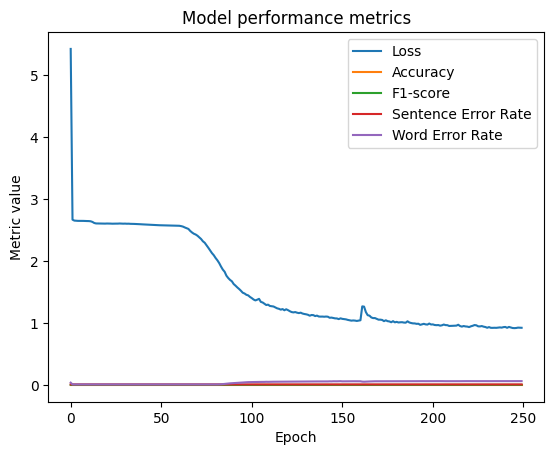

In [187]:
import matplotlib.pyplot as plt

# Plot the metrics on the same graph
plt.plot(train_rnn['loss'], label='Loss')
plt.plot(train_rnn['accuracy'], label='Accuracy')
plt.plot(train_rnn['f1-score'], label='F1-score')
plt.plot(train_rnn['ser'], label='Sentence Error Rate')
plt.plot(train_rnn['wer'], label='Word Error Rate')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Model performance metrics')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [188]:
for sample in test_datalader:
    model_input = sample[0].float().to(device)
    target_texts = sample[4]

    with torch.no_grad():
        prediction = model_rnn(model_input)

        for i in range(prediction.size(1)):
            predicted_text = greedy_CTC_decoder(prediction[:, i], int_to_char)
            print("Predicted:")
            print(predicted_text)
            print("Target:")
            print(target_texts[i])
            print('-----------------------------------------------------------------------------')
        # print('-----------------------------------------------------------------------------')

Predicted:
قل  ه ان هاروشستاده بدن اس هم بوم تر بودانهاهسم ردند بر با دنا حستن
Target:
قله ایی که انها رویش ایستاده بودند از همه بلندتر بود ان ها حس می کردند بر بام دنیا هستند
-----------------------------------------------------------------------------
Predicted:
فز رزد بزمستن دتودهه دانزز  بدشابددت ش زنتتبن بتن د خوقهددزخ
Target:
پس از ان که به بستر رفتند تا مدتی دراز از اینده ی درخشانی که در پیش داشتند حرف زدند و همین که خواب رفتند خوابهای شیرین دیدند
-----------------------------------------------------------------------------
Predicted:
هروداز شمادرم جاب وازا ت تووازادرا استت
Target:
هر کدوم از شما در انجام وظایف اتون ازاد رها هستین
-----------------------------------------------------------------------------
Predicted:
توم فته درواقند  دمبدسترمده ره هم بهدامنه دممرمطن پر د دشتم
Target:
تومک گفت در واقع من قصد دارم به راهم ادامه بدم تردید داشتم
-----------------------------------------------------------------------------
Predicted:
البالوسر استدنتا جد ورسنشان معت هاب مدنشمه
Target

# Training GRU

In [190]:
model_gru = GRU()

In [191]:
criterion = nn.CTCLoss()

optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)

In [192]:
model_gru = model_gru.to(device)

In [193]:
model_gru, train_gru, valid_gru = train(model_gru, 250, dataloaders, criterion, optimizer, device, 'GRU training')

  0%|          | 0/250 [00:00<?, ?it/s]

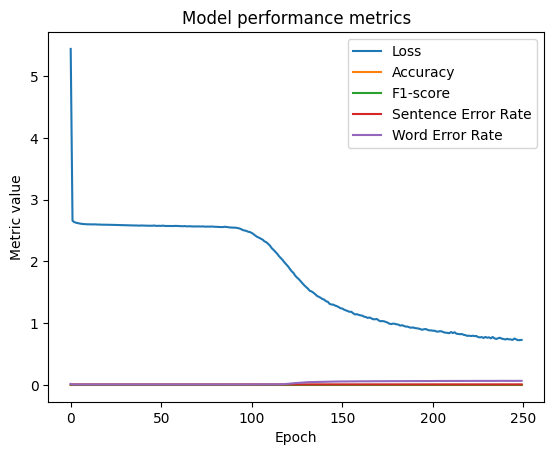

In [196]:
import matplotlib.pyplot as plt

# Plot the metrics on the same graph
plt.plot(train_gru['loss'], label='Loss')
plt.plot(train_gru['accuracy'], label='Accuracy')
plt.plot(train_gru['f1-score'], label='F1-score')
plt.plot(train_gru['ser'], label='Sentence Error Rate')
plt.plot(train_gru['wer'], label='Word Error Rate')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Model performance metrics')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [197]:
for sample in test_datalader:
    model_input = sample[0].float().to(device)
    target_texts = sample[4]

    with torch.no_grad():
        prediction = model_gru(model_input)

        for i in range(prediction.size(1)):
            predicted_text = greedy_CTC_decoder(prediction[:, i], int_to_char)
            print("Predicted:")
            print(predicted_text)
            print("Target:")
            print(target_texts[i])
            print('----------------------------------------')

Predicted:
از هافتاد اس خستد  خوش بخت رو سن دراس شد و خود را به دستت نوازششرن افتاد
Target:
از پا افتاده از خستگی خوشبختی روی سنگی دراز کشید و خود را به دست نوازش شیرین افتاب
----------------------------------------
Predicted:
امان بار دلاور برمج بابرندنش ارشرد مج   ازتتاب ان وف
Target:
اما اینبار دلاور بر موجی باورنکردنی شناور شد موجی که هیچ کس تا ان وقت
----------------------------------------
Predicted:
ان ل ابانج در انتا فابان بهله نج و در مجنوه بام تهران قرار دارد د منطقه ش مان اط واشد است
Target:
این تله کابین که در انتهای خیابان ولنجک در مجموعه ی بام تهران قرار دارد در منطقه ی شمیرانات واقع شده است
----------------------------------------
Predicted:
نا هان در ان وه  ناشناخته ند ند و متومنثند انها را در اب اوششان بهفشرد
Target:
ناگهان در این جزیره ی ناشناخته می دیدند و می توانستند انها را در اغوششان بفشارند
----------------------------------------
Predicted:
شب اخد ل ا بلاز ان هه همه ز را خوود برس ر پشته پش انه ش نشاست
Target:
شب اخر بعد از انکه همه چیز را خوب بررسی کرد پشت پیشخو

# Training LSTM

In [199]:
model_lstm = LSTM()

In [200]:
criterion = nn.CTCLoss()

optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

In [201]:
model_lstm = model_lstm.to(device)

In [202]:
model_lstm, train_lstm, valid_lstm = train(model_lstm, 250, dataloaders, criterion, optimizer, device, 'LSTM training')

  0%|          | 0/250 [00:00<?, ?it/s]

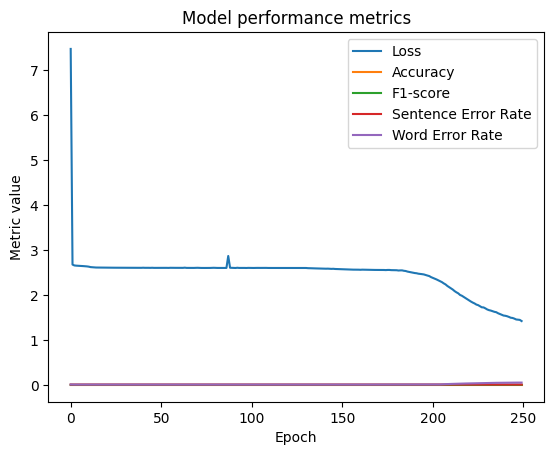

In [205]:
import matplotlib.pyplot as plt

# Plot the metrics on the same graph
plt.plot(train_lstm['loss'], label='Loss')
plt.plot(train_lstm['accuracy'], label='Accuracy')
plt.plot(train_lstm['f1-score'], label='F1-score')
plt.plot(train_lstm['ser'], label='Sentence Error Rate')
plt.plot(train_lstm['wer'], label='Word Error Rate')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Model performance metrics')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [206]:
for sample in test_datalader:
    model_input = sample[0].float().to(device)
    target_texts = sample[4]

    with torch.no_grad():
        prediction = model_lstm(model_input)

        for i in range(prediction.size(1)):
            predicted_text = greedy_CTC_decoder(prediction[:, i], int_to_char)
            print("Predicted:")
            print(predicted_text)
            print("Target:")
            print(target_texts[i])
            print('----------------------------------------------------------------')

Predicted:
وو شازامنشت وو ا برز مسو م شو دامن جروب وشا با شرتران مجادر وب ان بن شر
Target:
و بخشی از دامنه ی رشته کوه البرز محسوب می شود دامنه ی جنوبی توچال با شهر تهران مجاور و قله ی ان به این شهر
----------------------------------------------------------------
Predicted:
ششت  شرر ا ر مش مششمنامد م ش از ماات باساندنب ر بش شر
Target:
چشمه علی در شهر ری که در گویش محلی چشم علی نامیده می شود از نقاط باستانی دیدنی و گردشگری شهر ری
----------------------------------------------------------------
Predicted:
بوششج ش م دروزسا ماسندرشت شنا زر سختاس مان ب خا ب وش هم داشت دو بس
Target:
یک پوشش پشمی درست حسابی لازم داشت چون او باید زیر سقف اسمان بخوابد و شب هم داشت رو به
----------------------------------------------------------------
Predicted:
خو هاز جاو با همنز م تدا د  اا مرادخودرشمس  ب
Target:
خب از اینجا به بعد هم اندازه ی ما اطلاعات دارین حالا دیگه میل انتخاب با شماست که برید
----------------------------------------------------------------
Predicted:
ه رو م ه امن بااما پدا ه ماتردش بشما
Ta

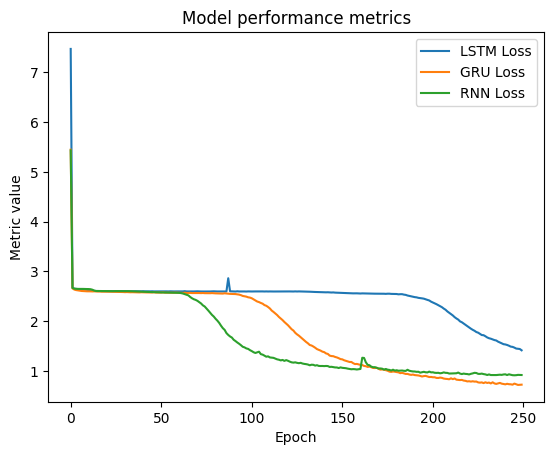

In [208]:
import matplotlib.pyplot as plt


plt.plot(train_lstm['loss'], label='LSTM Loss')

plt.plot(train_gru['loss'], label='GRU Loss')

plt.plot(train_rnn['loss'], label='RNN Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Model performance metrics')

# Add legend
plt.legend()

# Show the plot
plt.show()

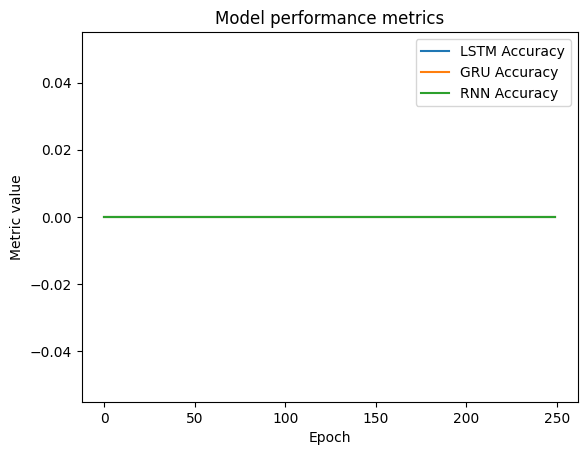

In [209]:
import matplotlib.pyplot as plt


plt.plot(train_lstm['accuracy'], label='LSTM Accuracy')

plt.plot(train_gru['accuracy'], label='GRU Accuracy')

plt.plot(train_rnn['accuracy'], label='RNN Accuracy')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Model performance metrics')

# Add legend
plt.legend()

# Show the plot
plt.show()

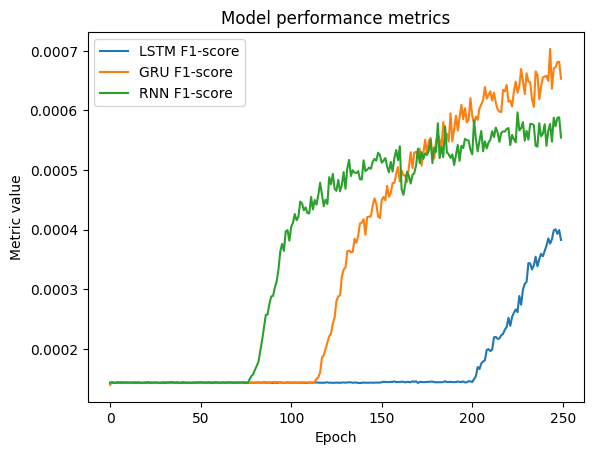

In [210]:
import matplotlib.pyplot as plt


plt.plot(train_lstm['f1-score'], label='LSTM F1-score')

plt.plot(train_gru['f1-score'], label='GRU F1-score')

plt.plot(train_rnn['f1-score'], label='RNN F1-score')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Model performance metrics')

# Add legend
plt.legend()

# Show the plot
plt.show()

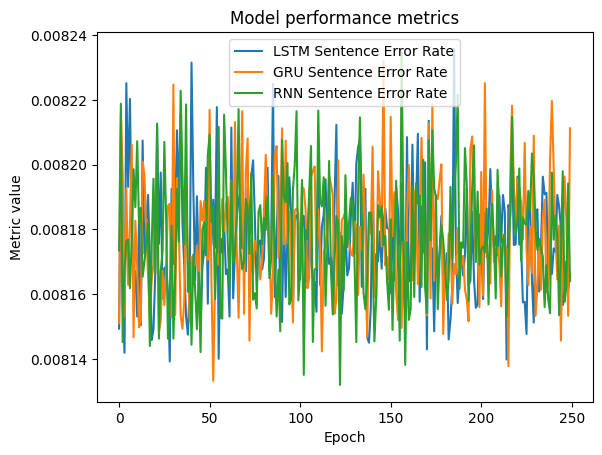

In [211]:
import matplotlib.pyplot as plt


plt.plot(train_lstm['ser'], label='LSTM Sentence Error Rate')

plt.plot(train_gru['ser'], label='GRU Sentence Error Rate')

plt.plot(train_rnn['ser'], label='RNN Sentence Error Rate')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Model performance metrics')

# Add legend
plt.legend()

# Show the plot
plt.show()

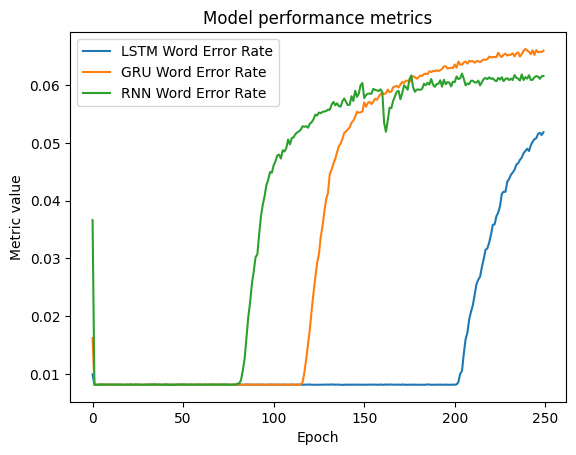

In [212]:
import matplotlib.pyplot as plt


plt.plot(train_lstm['wer'], label='LSTM Word Error Rate')

plt.plot(train_gru['wer'], label='GRU Word Error Rate')

plt.plot(train_rnn['wer'], label='RNN Word Error Rate')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Model performance metrics')

# Add legend
plt.legend()

# Show the plot
plt.show()